In this kernel I will train a pre-existing DCNN, the Inception V3, to make it able to classify the breed of any dog given in the input image.
The training will involve the training of both the Feature extractor and the classifier.

In [1]:
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler, random_split
import torch.nn as nn

from PIL import Image
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xml.etree.ElementTree as ET


torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

After importing the necessary modules, we'll first define a function that finds the bounding boxes using the maximum and minimum x and y values from the annotation files and crops the images accordingly

In [2]:
def crop_image(breed, dog, data_dir):
    tree = ET.parse(data_dir + "annotations/" + breed + "/" + dog)
    bounding_box = tree.getroot().findall("object")[0].find("bndbox")
    xmin = int(bounding_box.find("xmin").text)
    xmax = int(bounding_box.find("xmax").text)
    ymin = int(bounding_box.find("ymin").text)
    ymax = int(bounding_box.find("ymax").text)
    return plt.imread(data_dir + "images/" + breed + "/" + dog + ".jpg")[
        ymin:ymax, xmin:xmax, :
    ]


To help visualise and ensure that we are cropping correctly, I've randomly chosen 4 images and displayed how the images are cropped with the annotations below.

cuda:0


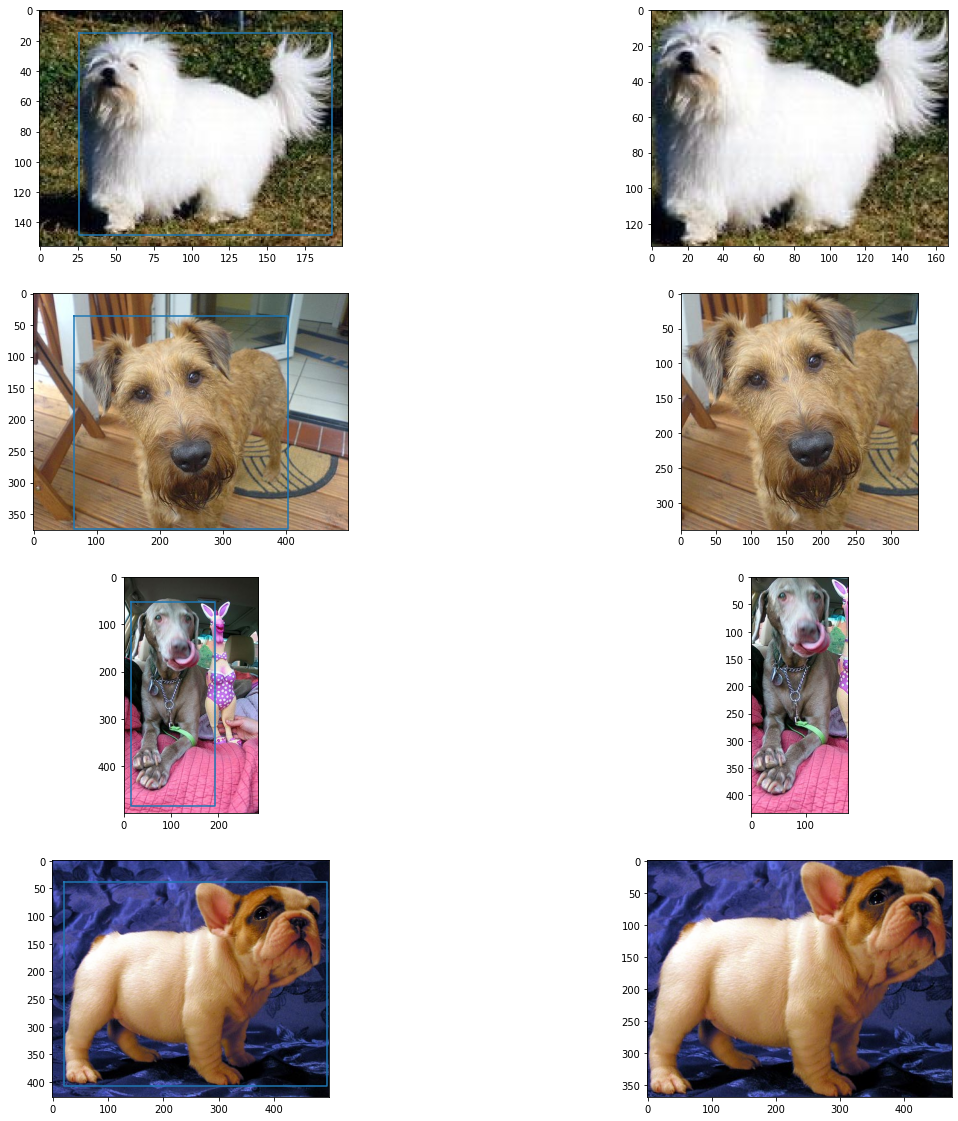

In [3]:
data_dir = '../data/'
breed_list = os.listdir(data_dir + 'images/')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def plot_sample_image_vs_crop(data_dir):
  plt.figure(figsize=(20, 20))
  for i in range(4):
    plt.subplot(421 + (i*2))
    breed = np.random.choice(breed_list)
    dog = np.random.choice(os.listdir(data_dir + 'annotations/' + breed))
    img = plt.imread(data_dir + 'images/' + breed + '/' + dog + '.jpg')
    plt.imshow(img)  

    tree = ET.parse(data_dir + 'annotations/' + breed + '/' + dog)
    boundingBox = tree.getroot().findall('object')[0].find('bndbox')
    xmin = int(boundingBox.find('xmin').text)
    xmax = int(boundingBox.find('xmax').text)
    ymin = int(boundingBox.find('ymin').text)
    ymax = int(boundingBox.find('ymax').text)
    plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin])
    crop_img = crop_image(breed, dog, data_dir)
    plt.subplot(422 + (i*2))
    plt.imshow(crop_img)

plot_sample_image_vs_crop(data_dir=data_dir)

Next, we'll create new folders to store all the cropped images, which we will use to train the classifier

And we'll save the cropped images to their breed folders

In [4]:
from multiprocessing import Pool

def save_image(breed_and_file):
    global data_dir
    img = Image.open(''.join([data_dir, 'images/', breed_and_file, '.jpg']))
    tree = ET.parse(''.join([data_dir, 'annotations/', breed_and_file]))
    boundingBox = tree.getroot().findall('object')[0].find('bndbox')
    xmin = int(boundingBox.find('xmin').text)
    xmax = int(boundingBox.find('xmax').text)
    ymin = int(boundingBox.find('ymin').text)
    ymax = int(boundingBox.find('ymax').text)
    img = img.crop((xmin,ymin,xmax,ymax))
    img = img.convert('RGB')
    img.save(''.join([data_dir, 'croped_images/', breed_and_file, '.jpg'])) 

In [5]:
from itertools import chain

def parallel_save_cropped_images(data_dir, breed_list):
    with Pool() as pool:
        pool.map(
            func=save_image,
            iterable=list(
                chain.from_iterable(
                    [
                        [
                            "".join([breed, "/", file])
                            for file in os.listdir(
                                "".join([data_dir, "annotations/", breed])
                            )
                        ]
                        for breed in breed_list
                    ]
                )
            ),
            chunksize=50
        )

try:
    if data_dir + 'croped_images/' not in os.listdir():
        os.mkdir(data_dir + 'croped_images/')
        for breed in breed_list:
            os.mkdir(data_dir + 'croped_images/' + breed)
        print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir(data_dir))))
        parallel_save_cropped_images(data_dir, breed_list)
except FileExistsError:
    print("Already existing file")

Already existing file


In [6]:
img_count = 0

for folder in os.listdir(data_dir + 'croped_images/'):
    img_count += len(os.listdir(data_dir + 'croped_images/' + folder))
print('No. of Images: {}'.format(img_count))

No. of Images: 20580


Great, now all our cropped images are in place. We'll now define the data augmentation and normalizations for the data. The training data will have augmentations to increase the variability of training images. We'll use random rotations, random crops and some other augmentations for the training transforms. Both training and test data will then be resized to 299 * 299 as this is the standard input size for the inception model. The images will be normalized as well according to the ImageNet standards.



In [7]:
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=315, scale=(0.95, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=299),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=299),
        transforms.CenterCrop(size=299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

We'll now define the batch size (which can be modified depending on how you want to train your model) and split the data into training, validation and test sets.

In [8]:
batch_size = 32

all_data = datasets.ImageFolder(root=data_dir + 'croped_images/')
train_data_len = int(len(all_data)*0.8)
valid_data_len = int((len(all_data) - train_data_len)/2)
test_data_len = int(len(all_data) - train_data_len - valid_data_len)
train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
train_data.dataset.transform = image_transforms['train']
val_data.dataset.transform = image_transforms['test']
test_data.dataset.transform = image_transforms['test']
print(len(train_data), len(val_data), len(test_data))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

16464 2058 2058


In [9]:
trainiter = iter(train_loader)
features, labels = next(trainiter)
print(features.shape, labels.shape)

torch.Size([64, 3, 299, 299]) torch.Size([64])


After making sure that our data loaders are outputting data of the correct dimensions (batch_size, 3, 299, 299), we can now instantiate the model by loading it with pre-trained weights. Specifically for the Inception model, we'll have to set the aux_logits property to False. We can then see the model architecture(which is very long).

In [10]:
model = models.inception_v3(pretrained=True)
model.aux_logits=False
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

Next, we'll freeze the earlier layers in the model as we do not want to re-train these weights, which are responsible for the model's success in picking out key features of the image.

In [11]:
# Freeze early layers
for param in model.parameters():
    param.requires_grad = True
    # param.requires_grad = False


Instead, the only layers which we will be training is the classifier layer, or defined as the fc layer for the case of the Inception model. We have to ensure that the final output will be 120 as we have 120 possible different classes.

In [12]:
n_classes = 120
n_inputs = model.fc.in_features
# n_inputs will be 4096 for this case
# Add on classifier
model.fc = nn.Sequential(
    nn.Linear(n_inputs, 1024),
    nn.ReLU(),
    nn.Dropout(0.35),
    nn.Linear(1024, n_classes),
    nn.LogSoftmax(dim=1)).to(device)

model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.35, inplace=False)
  (3): Linear(in_features=1024, out_features=120, bias=True)
  (4): LogSoftmax(dim=1)
)

Sending the model to GPU, if not it'll take forever to train. This is followed by defining the criterion and optimizer.

In [13]:
from pickletools import optimize

if torch.cuda.is_available():
    model.cuda()
    print("-- Cuda enabled --")
criterion = nn.NLLLoss()
# optimizer = optim.AdamW(model.parameters(), lr=0.0005)
# If the batch size is doubled should be also the learning rate.
# optimizer = optim.Adam(model.parameters(), lr=0.0005)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=5,mode="triangular")
# optimizer = torch.optim.SGD(model.parameters(), lr=100)
# lmbda = lambda epoch: 0.65 ** epoch
# scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
# optimizer = torch.optim.SGD(model.parameters(), lr=100)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=5,mode="triangular2")
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0.01, last_epoch=-1)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.01, last_epoch=-1)
# optimizer = torch.optim.SGD(model.parameters(), lr=100)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=5,mode="exp_range",gamma=0.85)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-3, max_lr=0.1,step_size_up=5,mode="triangular2")
# optimizer = torch.optim.SGD(model.parameters(), lr=100)
# lmbda = lambda epoch: 0.65 ** epoch
# scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=10, epochs=10)

-- Cuda enabled --


Creating an index for the 120 different classes/breeds below

In [14]:
model.class_to_idx = all_data.class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

[(0, 'n02085620-Chihuahua'),
 (1, 'n02085782-Japanese_spaniel'),
 (2, 'n02085936-Maltese_dog'),
 (3, 'n02086079-Pekinese'),
 (4, 'n02086240-Shih-Tzu'),
 (5, 'n02086646-Blenheim_spaniel'),
 (6, 'n02086910-papillon'),
 (7, 'n02087046-toy_terrier'),
 (8, 'n02087394-Rhodesian_ridgeback'),
 (9, 'n02088094-Afghan_hound'),
 (10, 'n02088238-basset'),
 (11, 'n02088364-beagle'),
 (12, 'n02088466-bloodhound'),
 (13, 'n02088632-bluetick'),
 (14, 'n02089078-black-and-tan_coonhound'),
 (15, 'n02089867-Walker_hound'),
 (16, 'n02089973-English_foxhound'),
 (17, 'n02090379-redbone'),
 (18, 'n02090622-borzoi'),
 (19, 'n02090721-Irish_wolfhound'),
 (20, 'n02091032-Italian_greyhound'),
 (21, 'n02091134-whippet'),
 (22, 'n02091244-Ibizan_hound'),
 (23, 'n02091467-Norwegian_elkhound'),
 (24, 'n02091635-otterhound'),
 (25, 'n02091831-Saluki'),
 (26, 'n02092002-Scottish_deerhound'),
 (27, 'n02092339-Weimaraner'),
 (28, 'n02093256-Staffordshire_bullterrier'),
 (29, 'n02093428-American_Staffordshire_terrier'),


Now, we'll define the training function which will run over the specified number of epochs. It will take the data from the train loader and update the weights of the fc layer according to the labels.

Every 2 epochs, the function will do validation using the data from the validation loader and ensure that the loss is still decreasing. If the loss stops decreasing for a certain number of epochs (which is defined through the early_stop hyper-parameter), the model will stop training and save the previous the best weights instead

In [15]:
import requests


def send_telegram_message(message):
    chat_id = -774133225
    token = "5489914510:AAG3FrNtEpmJLpaGoqirJwIYlSkYlq4WtBg"
    requests.get(
        "".join(
            [
                "https://api.telegram.org/bot",
                str(token),
                "/sendMessage?chat_id=",
                str(chat_id),
                "&text=",
                str(message),
            ]
        )
    )

In [16]:
# TODO: DEVI fare in modo durante l'esecuzione di salvare su una variabile
# il modello che si comporta meglio, e poi verifiche se a parita' di parametri
# si e' comportato meglio di quello corrispondente gia' salvato, e in tal caso
# lo salvi in memoria.


def train(
    model,
    device,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_location,
    early_stop=3,
    n_epochs=20,
    print_every=2,
):
    valid_loss_min = np.Inf
    stop_count = 0
    valid_max_acc = 0
    history = []
    model.epochs = 0
    model.to(device)

    for epoch in range(n_epochs):

        train_loss = 0
        valid_loss = 0

        train_acc = 0
        valid_acc = 0

        model.train()
        ii = 0

        for data, label in train_loader:
            ii += 1
            data, label = data.cuda(), label.cuda()
            # @FIXME: ORIGINAL : optimizer.zero_grad()
            optimizer.zero_grad(set_to_none=True)
            output = model(data)

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            # TRACKING TRAIN LOSS: by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(
                output, dim=1
            )  # first output gives the max value in the row(not what we want), second output gives index of the highest val
            # correct_tensor = pred.eq(
            #     label.data.view_as(pred)
            # )  # using the index of the predicted outcome above, torch.eq() will check prediction index against label index to see if prediction is correct(returns 1 if correct, 0 if not)
            # accuracy = torch.mean(
            #     correct_tensor.type(torch.FloatTensor)
            # )  # tensor must be float to compute average
            train_acc += torch.mean(
                pred.eq(label.data.view_as(pred)).type(torch.FloatTensor)
            ).item() * data.size(0)
            if ii % 10 == 0:
                print(
                    f"Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete."
                )

        model.epochs += 1
        with torch.no_grad():
            model.eval()

            for data, label in val_loader:
                data, label = data.cuda(), label.cuda()

                output = model(data)
                loss = criterion(output, label)
                valid_loss += loss.item() * data.size(0)

                _, pred = torch.max(output, dim=1)
                # correct_tensor = pred.eq(label.data.view_as(pred))
                # accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                valid_acc += torch.mean(
                    pred.eq(label.data.view_as(pred)).type(torch.FloatTensor)
                ).item() * data.size(0)

            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(val_loader.dataset)

            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(val_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # if (epoch + 1) % print_every == 0:
            message = f"\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}\n\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%"
            send_telegram_message(message=message)
            print(message)

            # EARLY STOP CHECK:
            if valid_loss < valid_loss_min:
                torch.save(
                    {
                        "state_dict": model.state_dict(),
                        "idx_to_class": model.idx_to_class,
                    },
                    save_location,
                )
                stop_count = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            else:
                stop_count += 1
                if stop_count >= early_stop:
                    message = f"\nEarly Stopping Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%"
                    print(message)

                    model.load_state_dict(torch.load(save_location)["state_dict"])
                    model.optimizer = optimizer
                    history = pd.DataFrame(
                        history,
                        columns=["train_loss", "valid_loss", "train_acc", "valid_acc"],
                    )
                    return model, history

    model.optimizer = optimizer
    message = f"\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%"
    send_telegram_message(message=message)
    print(message)

    history = pd.DataFrame(
        history, columns=["train_loss", "valid_loss", "train_acc", "valid_acc"]
    )
    return model, history


In [17]:
del breed_list, n_classes, n_inputs, features, img_count, val_data, image_transforms #all_data,

In [18]:

try:
    model, history = train(
        model,
        device,
        criterion,
        optimizer,
        train_loader,
        val_loader,
        save_location='./dog_inception.pt',
        early_stop=3,
        n_epochs=80,
        print_every=2)
except:
    send_telegram_message("--- CNN EXECUTION ERROR! ---")

send_telegram_message("---TRAINING COMPLETED---")

In [19]:
history

from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler, random_split
import torch.nn as nn

from PIL import Image
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xml.etree.ElementTree as ET


torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)
def crop_image(breed, dog, data_dir):
    tree = ET.parse(data_dir + "annotations/" + breed + "/" + dog)
    bounding_box = tree.getroot().findall("object")[0].find("bndbox")
    xmin = int(bounding_box.find("xmin").text)
    xmax = int(bounding_box.find("xmax").text)
    ymin = int(bounding_box.find("ymin").text)
    ymax = int(bounding_box.find("ymax").text)
    return plt.imread(data_dir + "images/" + breed + "/" + dog + ".jpg")[
        ymin:ymax, xmin:xmax, :
    ]
data_dir = '../data/'
breed_list = os.listdir(data_dir + 'images/')
device = t

After training for just a few epochs, we can see that the accuracy on the validation training set is around 75%. To ensure that the model isn't overfitting for the training and validation data, let's test the model out using the test data which it has not seen at all yet.

In [20]:
def test(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        test_acc = 0
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()

            output = model(data)

            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(label.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            test_acc += accuracy.item() * data.size(0)

        test_acc = test_acc / len(test_loader.dataset)
        return test_acc

In [21]:
model.load_state_dict(torch.load('./dog_inception.pt')['state_dict'])
test_acc = test(model.cuda(), test_loader, criterion)
print(f'The model has achieved an accuracy of {100 * test_acc:.2f}% on the test dataset')

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

The accuracy we achieved is not too bad considering that some dog breeds can be extremely similar and we may not be able to distinguish them with our eyes ourselves

In [ ]:
def evaluate(model, test_loader, criterion):
  
    classes = []
    acc_results = np.zeros(len(test_loader.dataset))
    i = 0

    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.cuda(), labels.cuda()
            output = model(data)

            for pred, true in zip(output, labels):
                _, pred = pred.unsqueeze(0).topk(1)
                correct = pred.eq(true.unsqueeze(0))
                acc_results[i] = correct.cpu()
                classes.append(model.idx_to_class[true.item()][10:])
                i+=1

    results = pd.DataFrame({
      'class': classes,
      'results': acc_results    
    })
    results = results.groupby(classes).mean()

    return results

In [ ]:
print(evaluate(model, test_loader, criterion))

                                 results
Afghan_hound                    1.000000
African_hunting_dog             1.000000
Airedale                        0.900000
American_Staffordshire_terrier  0.714286
Appenzeller                     0.769231
...                                  ...
toy_poodle                      0.733333
toy_terrier                     0.705882
vizsla                          0.705882
whippet                         0.520000
wire-haired_fox_terrier         0.791667

[120 rows x 1 columns]


The table above shows the accuracy of our model on the specific breeds, with a score of 1 showing that our model classified that breed correctly. As we can see, some of the breeds have rather bad accuracy, probably because of their similarities, which the model could not pick out the fine-grained differences.